In [61]:
# !pip install h3==3.7.6 --force-reinstall
# !pip install --upgrade shapely
# !pip install osmnx --upgrade
# !pip install shap
# !pip install lightgbm
# !pip install optuna

!pip install yellowbrick

In [62]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3
import gzip
import shutil
import os
from shapely.geometry import Point
from shapely.geometry import Polygon
from h3 import geo_to_h3, h3_to_geo
import time
import logging
from datetime import datetime
import seaborn as sns
import matplotlib
matplotlib.rc('font', family='DejaVu Sans')
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import optuna
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [77]:
H3_RESOLUTION = 8
TARGET_TYPE = 'Sewer: Blocked/Overflow'

In [64]:
#load the data

start_time = time.time()

file_name = "sr_hex.csv.gz"
var_name = "df_sr_hex"
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/"
url = base_url + file_name

print(f"Processing {file_name}...")
!wget -q {url}

# Unzip and load
csv_name = file_name[:-3]  
with gzip.open(file_name, 'rb') as f_in:
    with open(csv_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

os.remove(file_name)  

df = pd.read_csv(csv_name)

print(f"Loaded {file_name} in {time.time() - start_time:.2f} seconds")

Processing sr_hex.csv.gz...


Loaded sr_hex.csv.gz in 9.71 seconds


In [65]:
# Drop Records where h3_level8_index = '0' / is missing
print(df.shape)
df = df.loc[df.h3_level8_index != '0']
print(df.shape)

(941634, 16)
(729270, 16)


In [ ]:
#Filter out records for TARGET_TYPE


df_type = df[df['code'] == TARGET_TYPE].groupby(['h3_level8_index'])['notification_number'].count().reset_index(name='num_requests')

In [67]:
df_type.head(2)

,h3_level8_index,num_requests
0,88ad360001fffff,21
1,88ad360003fffff,12


In [68]:
#Helper function
def h3_to_point(h3, resolution=8):
    return h3_to_geo(h3)

# Convert each h3_index to lat/lon
df_type[['latitude', 'longitude']] = df_type['h3_level8_index'].apply(lambda h: pd.Series(h3_to_point(h)))

In [69]:
df_type.head(2)

,h3_level8_index,num_requests,latitude,longitude
0,88ad360001fffff,21,-33.836215,18.494065
1,88ad360003fffff,12,-33.832471,18.485002


## Initial Solution - Baseline Model

In [70]:

X = df_type.drop(['num_requests'], axis=1)
X = X.set_index('h3_level8_index')
y = df_type['num_requests']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

#_train = np.log1p(y_train)
regressor = RandomForestRegressor(n_estimators = 50,oob_score = True)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
#y_pred = np.expm1(y_log_pred)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

Out-of-Bag Score: 0.28829043409517463
RMSE: 114.61433570429212
R2: 0.3068861687582174


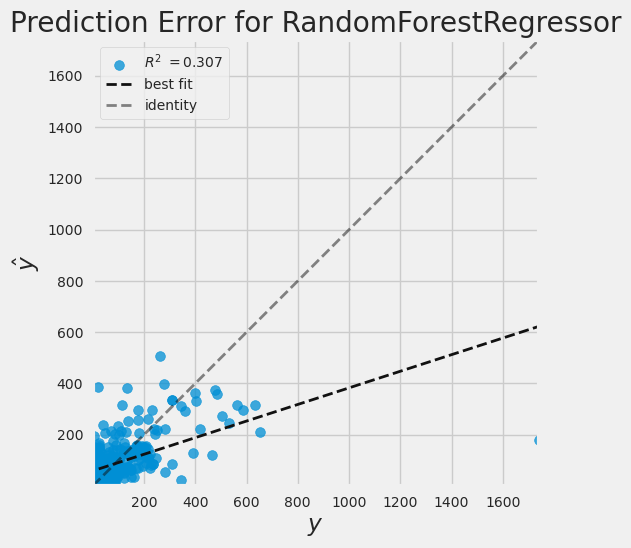

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [71]:
visualizer = PredictionError(regressor)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

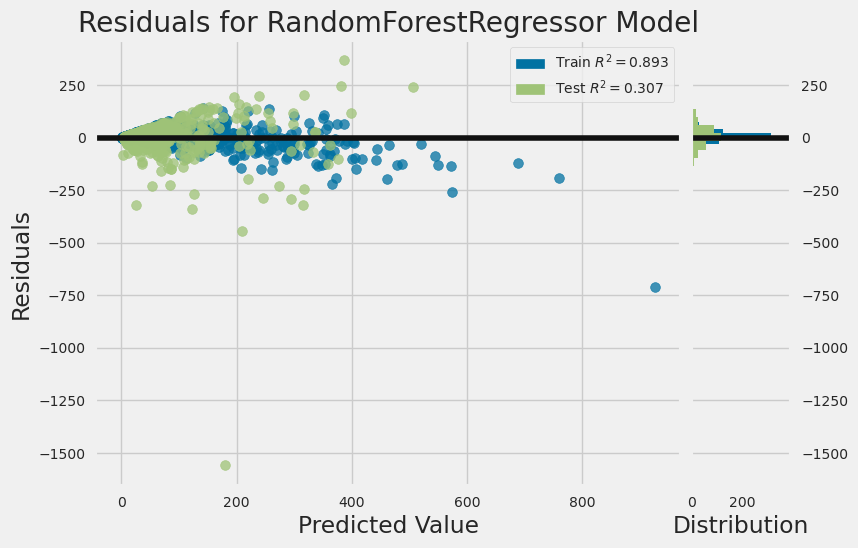

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [72]:
visualizer = ResidualsPlot(regressor)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

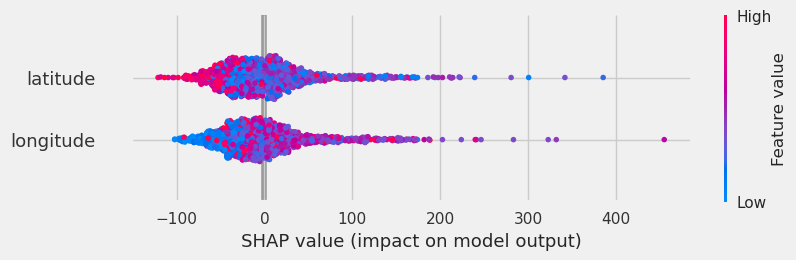

In [73]:
explainer = shap.Explainer(regressor)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values)

## Improved Solution
### Feature Engineering - Add External Data

In [74]:
# Features from OpenStreetMaps  (https://wiki.openstreetmap.org/wiki/Map_features)

# -------------------------------
# Settings
# -------------------------------
place_name = "City of Cape Town, Western Cape, South Africa"
resolution = 8

feature_tags = {
    "num_schools": {"amenity": "school"},
    "num_shops": {"shop": True},
    "num_bus_stops": {"highway": "bus_stop"},
    "num_clinics": {"amenity": "clinic"},
    "num_hospitals": {"amenity": "hospital"},
    "num_post_offices": {"amenity": "post_office"},
    "num_pharmacies": {"amenity": "pharmacy"},
    "num_banks": {"amenity": "bank"},
    "num_traffic_signals": {"highway": "traffic_signals"},
    "num_religious_sites": {"amenity": ["place_of_worship", "church", "mosque", "synagogue", "temple"]},
}

# -------------------------------
# Get Cape Town polygon using unary_union
# -------------------------------
print("Fetching Cape Town boundary...")
gdf_boundary = ox.geocode_to_gdf(place_name)
polygon = gdf_boundary.geometry.unary_union

# -------------------------------
# Helper functions
# -------------------------------
def point_to_h3(point, resolution=8):
    return h3.geo_to_h3(point.y, point.x, resolution)

def extract_and_aggregate(tag_label, tag_filter):
    print(f"Fetching {tag_label}...")
    try:
        time.sleep(2)
        gdf = ox.features_from_polygon(polygon, tags=tag_filter)
    except Exception as e:
        print(f"Failed to fetch {tag_label}: {e}")
        return pd.DataFrame(columns=["h3_level8_index", tag_label])

    gdf = gdf[gdf.geometry.notna()].copy()

    if gdf.geom_type.isin(['Polygon', 'MultiPolygon']).any():
        gdf['geometry'] = gdf['geometry'].centroid

    gdf = gdf[gdf.geometry.type == 'Point']
    gdf['h3_level8_index'] = gdf['geometry'].apply(lambda pt: point_to_h3(pt, resolution))

    agg = gdf.groupby('h3_level8_index').size().reset_index(name=tag_label)
    return agg

# -------------------------------
# Loop and Merge All Features
# -------------------------------
from functools import reduce

h3_feature_dfs = []

for label, tag in feature_tags.items():
    h3_df = extract_and_aggregate(label, tag)
    h3_feature_dfs.append(h3_df)

print("Merging all feature tables...")
df_h3_features = reduce(
    lambda left, right: pd.merge(left, right, on='h3_level8_index', how='outer'),
    h3_feature_dfs
)

df_h3_features.fillna(0, inplace=True)

# -------------------------------
# Final Output
# -------------------------------
print("Final H3 feature summary:")


Fetching Cape Town boundary...
Fetching num_schools...


Fetching num_shops...
Fetching num_bus_stops...
Fetching num_clinics...
Fetching num_hospitals...
Fetching num_post_offices...
Fetching num_pharmacies...
Fetching num_banks...
Fetching num_traffic_signals...
Fetching num_religious_sites...
Merging all feature tables...
Final H3 feature summary:


In [75]:
df_h3_features.head().T

,0,1,2,3,4
h3_level8_index,88ad360003fffff,88ad360005fffff,88ad360007fffff,88ad360021fffff,88ad360023fffff
num_schools,0.0,1.0,1.0,1.0,1.0
num_shops,0.0,1.0,1.0,0.0,2.0
num_bus_stops,0.0,0.0,0.0,4.0,5.0
num_clinics,0.0,0.0,0.0,0.0,0.0
num_hospitals,0.0,0.0,0.0,0.0,0.0
num_post_offices,0.0,0.0,0.0,0.0,0.0
num_pharmacies,0.0,0.0,1.0,0.0,0.0
num_banks,0.0,0.0,0.0,0.0,2.0
num_traffic_signals,5.0,4.0,11.0,1.0,0.0


In [76]:
#merge df_h3_features with df_type
print(df_type.shape)
df_type = pd.merge(df_type, df_h3_features, on='h3_level8_index', how='left')
df_type.fillna(0,inplace=True)
print(df_type.shape)
df_type.head()

(1501, 4)
(1501, 14)


,h3_level8_index,num_requests,latitude,longitude,num_schools,num_shops,num_bus_stops,num_clinics,num_hospitals,num_post_offices,num_pharmacies,num_banks,num_traffic_signals,num_religious_sites
0,88ad360001fffff,21,-33.836215,18.494065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,88ad360003fffff,12,-33.832471,18.485002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
2,88ad360005fffff,54,-33.832063,18.502176,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
3,88ad360007fffff,41,-33.828319,18.493112,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0
4,88ad36000dfffff,15,-33.839958,18.503130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
#Number of request types (excluding TARGET_TYPE)  per h3_level8_index

unique_types_per_hex = df[df.code != TARGET_TYPE].groupby('h3_level8_index')['code'].nunique().reset_index()
unique_types_per_hex.columns = ['h3_level8_index', 'num_unique_request_types']

# Preview result
unique_types_per_hex.sort_values('num_unique_request_types', ascending=False).head()

,h3_level8_index,num_unique_request_types
685,88ad361519fffff,185
716,88ad3615c1fffff,164
698,88ad361547fffff,164
697,88ad361545fffff,161
123,88ad36024bfffff,155


In [79]:
#merge unique_types_per_hex with df_type
print(df_type.shape)
df_type = pd.merge(df_type, unique_types_per_hex, on='h3_level8_index', how='left')
df_type.fillna(0,inplace=True)
print(df_type.shape)

(1501, 14)
(1501, 15)


In [82]:
#dominant request type per h3_level8_index excluding TARGET_TYPE

dominant_counts = (
    df[df.code != TARGET_TYPE].groupby(['h3_level8_index', 'code']).size()
    .reset_index(name='count')
    .sort_values(['h3_level8_index', 'count'], ascending=[True, False])
    .drop_duplicates('h3_level8_index')
    .rename(columns={'code': 'dominant_request_type', 'count': 'dominant_type_count'})
)

#merge dominant_counts with df_type
print(df_type.shape)
df_type = pd.merge(df_type, dominant_counts, on='h3_level8_index', how='left')
df_type.fillna(0,inplace=True)
print(df_type.shape)

(1501, 15)
(1501, 17)


In [90]:
df_type.dtypes

h3_level8_index              object
num_requests                  int64
latitude                    float64
longitude                   float64
num_schools                 float64
num_shops                   float64
num_bus_stops               float64
num_clinics                 float64
num_hospitals               float64
num_post_offices            float64
num_pharmacies              float64
num_banks                   float64
num_traffic_signals         float64
num_religious_sites         float64
num_unique_request_types    float64
dominant_request_type        object
dominant_type_count         float64
dtype: object

In [101]:
# Train the model

X = df_type.drop(columns = ["num_requests"], axis = 1)
X = X.set_index("h3_level8_index")
y = df_type["num_requests"]

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

#Ensure categorical columns are all string type
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

numeric_features = selector(dtype_include='number')(X_train)
categorical_features = selector(dtype_include='object')(X_train)

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
('regressor', LGBMRegressor(random_state=42))
])  #LGBMRegressor(random_state=42)  RandomForestRegressor(random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 1125, number of used features: 23
[LightGBM] [Info] Start training from score 85.727111
RMSE: 105.959589492705
R2: 0.4076106852143727


### Hyperparameter Tuning

In [103]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
    }
    num_cols = X.select_dtypes(include="number").columns.tolist()
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    
    numeric_pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler())])
    categorical_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))])
    
    preprocessor = ColumnTransformer([("num", numeric_pipeline, num_cols), ("cat", categorical_pipeline, cat_cols)])
    
    model = Pipeline([("pre", preprocessor), ("model",RandomForestRegressor(**params))]) 
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2025-07-06 12:02:20,550] A new study created in memory with name: no-name-b5437920-9d58-4354-9d77-0eda22be579d
[I 2025-07-06 12:02:20,684] Trial 0 finished with value: 124.80511298264038 and parameters: {'n_estimators': 122, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 124.80511298264038.
[I 2025-07-06 12:02:20,958] Trial 1 finished with value: 123.93167657553317 and parameters: {'n_estimators': 247, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 123.93167657553317.
[I 2025-07-06 12:02:21,339] Trial 2 finished with value: 105.88444339653027 and parameters: {'n_estimators': 101, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_features': 'auto'}. Best is trial 2 with value: 105.88444339653027.
[I 2025-07-06 12:02:21,618] Trial 3 finished with value: 112.34373584808802 and parameters: {'n_estimators': 242, 'max_depth': 10, '

Best hyperparameters: {'n_estimators': 225, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'auto'}
Best RMSE: 103.06808936818784


In [104]:
params =  study.best_params

num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()

numeric_pipeline = Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler())])
categorical_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([("num", numeric_pipeline, num_cols), ("cat", categorical_pipeline, cat_cols)])

model = Pipeline([("pre", preprocessor), ("model",RandomForestRegressor(**params))]) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

RMSE: 103.43899680368105
R2: 0.4354592680579895
